<a href="https://www.kaggle.com/code/vicmangiltafolla/titanic-hiperparam-tunning-with-voting-classifier?scriptVersionId=140605426" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic - Machine Learning from Disaster


##  Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import RobustScaler, Normalizer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.gridspec as gridspec
import seaborn as sns
import time
from joblib import dump, load

## Functions 

In [3]:
def countNan(df):
    for x in df:
        No_Nan_count = df[x].isna().value_counts()[0]
        Nan_count = len(df) - No_Nan_count
        if Nan_count > 0:
            print("Elements in {}\n".format(x)) 
            print("There are {} Nan values".format(Nan_count))
            print("There are {} No Nan values".format(No_Nan_count))
            print("---------------------------")
    print("___________________________") 
    
class FinalDataProcessor(BaseEstimator, TransformerMixin):
    '''Encode, scal and replace Nan values with any transformer using the fit/transform methods.
    
        The input should be an array-like of integers for the numeric transformation, numeric
        or string for the categorical one.
        '''
    def __init__(self,
                encoder=None,
                imputer=None,
                scaler=None,
                to_scal_cols=None,
                to_encod_cols=None):
        #Set transformers
        self.encoder = encoder
        self.imputer =imputer
        self.scaler = scaler
        self.to_scal_cols = to_scal_cols
        self.to_encod_cols = to_encod_cols
        
        #Set pipelines with the transformers
        num_pipeline = Pipeline([
                             ("imputer", self.imputer),
                             ("scaler", self.scaler)
        ])
        cat_pipeline = Pipeline([
                                ("imputer", self.imputer),
                                ("encoder", self.encoder)
        ])
        self._final_pipeline = ColumnTransformer([
            ("num", num_pipeline, self.to_scal_cols),
            ("cat", cat_pipeline, self.to_encod_cols)
        ])
    def fit(self, X, y=None):
        self._final_pipeline.fit(X)
        return self
    def transform(self, X, y=None):
        X = self._final_pipeline.transform(X)
        #Return a complete dataset with all the transformed values
        return pd.DataFrame(X, columns=(self._final_pipeline.get_feature_names_out()))

    
def TextProcess(row):
    #Clean the name attribute from punctuation marks 
    row = row.lower().replace('.', '')
    titles = ["master", "mr", "miss", "mrs", "ms", "sir", "lady", "dr", "rev", "fr", "capt", "col", "mme",
               "major", "mlle", "jonkheer", "countess", "uruchurtu", "dona"]
    #Replace the Name attribute with their corresponding title
    for name in str(row).split():
        if name in titles:
            return name

def predict(X_train,y_train,X_val, y_val,model):
    #Predicts and contrast different scores with the training and validation set
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    print("---Training set---\n")
    print("\t-Precision Score: {:.3f}\n".format(precision_score(y_train,y_train_pred)))
    print("\t-Accuracy Score: {:.3f}\n".format(accuracy_score(y_train,y_train_pred)))
    print("\t-F1 Score: {:.3f}\n".format(f1_score(y_train,y_train_pred)))
    print("\t-Recall Score: {:.3f}\n".format(recall_score(y_train, y_train_pred)))
    print("---Validation set---\n")
    print("\t-Precision Score: {:.3f}\n".format(precision_score(y_val,y_val_pred)))
    print("\t-Accuracy Score: {:.3f}\n".format(accuracy_score(y_val,y_val_pred)))
    print("\t-F1 Score: {:.3f}\n".format(f1_score(y_val,y_val_pred)))
    print("\t-Recall Score: {:.3f}\n".format(recall_score(y_val, y_val_pred)))

def CreateSub(origindf, preddf, model ,filename):
    #Creates a CSV file containing the predictions made by the final model to a 'Submissions' 
    preds = model.predict(preddf)
    passid = origindf["PassengerId"].copy()
    df_pred = pd.DataFrame(preds, columns=["Survived"])
    df_pred = pd.concat([passid,df_pred], axis="columns")
    df_pred.to_csv('/kaggle/working/' + filename + ".csv",index=False)

def PlotSurvCorrelation(df,column):
    #Plots the count of people who survived and didn't for each unique value in the selected column 

    #Get the names of the categories
    names = tuple(sorted(df[column].dropna().unique()))
    surv_dict = {'Survived': [], 'Not Survived': []}
    #Add the number of survivors in the dictionary for each category
    for name in names: 
        surv_dict['Survived'].append(len(df[column][df[column]==name][df["Survived"]==1]))
        surv_dict['Not Survived'].append(len(df[column][df[column]==name][df["Survived"]==0]))
    surv_dict['Survived'] = tuple(surv_dict['Survived'])
    surv_dict['Not Survived'] = tuple(surv_dict['Not Survived'])
    x = np.arange(len(names))
    multiplier = 0
    width = 0.25
    fig, ax = plt.subplots(figsize=(20,10))
    #Creates the bars setting the height as the count from before
    for surv, count in surv_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, count, width, label=surv)
        ax.bar_label(rects, padding=3)
        multiplier +=1
    ax.set_ylabel('Count')
    ax.set_title('Survival count by {}'.format(column))
    ax.set_xticks(x + width, names)
    ax.legend(loc='upper center')

## Dataset reading

In [4]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
#Counting of NaN elements in our dataset entries
countNan(df_train)
countNan(df_test)

## Data visualization

### Fare vs. Survived 

In [ ]:
fig , ax= plt.subplots(figsize=(20,15))
ax.scatter(df_train["PassengerId"][df_train["Survived"] == 1],
            df_train["Fare"][df_train["Survived"] == 1], label="Survived")
ax.scatter( df_train["PassengerId"][df_train["Survived"] == 0],
            df_train["Fare"][df_train["Survived"] == 0], label="Did not survived")
ax.set_ylabel("Fare", fontsize=25)
ax.legend()
plt.show()


#### Fare distribution

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(df_train["Fare"][df_train["Survived"] == 1], kde_kws={"label": "Survived"})
sns.distplot(df_train["Fare"][df_train['Survived'] == 0], kde_kws={"label": "Did not Survived"})
plt.show()

### Pclass vs. Survived

In [ ]:
PlotSurvCorrelation(df_train,"Pclass")

### SibSp vs. Survived

In [ ]:
PlotSurvCorrelation(df_train,"SibSp")

### Parch vs Survived 

In [ ]:
PlotSurvCorrelation(df_train,"Parch")

### Age vs Survived 

In [ ]:
fig , ax= plt.subplots(figsize=(20,15))
ax.scatter(df_train["PassengerId"][df_train["Survived"] == 1],
            df_train["Age"][df_train["Survived"] == 1], label="Survived")
ax.scatter( df_train["PassengerId"][df_train["Survived"] == 0],
            df_train["Age"][df_train["Survived"] == 0], label="Did not survived")
ax.set_ylabel("Age", fontsize=25)
ax.legend()
plt.show()


In [ ]:
PlotSurvCorrelation(df_train.head(200),"Age")

In [ ]:
PlotSurvCorrelation(df_train, "Embarked")

### Fare vs Pclass 

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))
ax.scatter(df_train["Fare"],df_train["Pclass"])
ax.set_xlabel("Fare",fontsize=20)
ax.set_ylabel("Pclass",fontsize=20)
plt.show()

## Dataset processing and cleaning

In [5]:
#Set an instance of the data processor with the transformers and the columns
processor = FinalDataProcessor(imputer=SimpleImputer(strategy="most_frequent"),
                              scaler=Normalizer(),
                              encoder=OneHotEncoder(handle_unknown="ignore"),
                              to_encod_cols=["Pclass", "Sex", 'Embarked'],
                              to_scal_cols = ["Age", "SibSp", "Parch", "Fare"])

In [6]:
#Transform the datasets and saving the label as 'y'
X = processor.fit_transform(df_train)
X_test = processor.transform(df_test)
y = df_train["Survived"].copy()

In [ ]:
X

In [ ]:
X_test

In [ ]:
countNan(X)
countNan(X_test)

### Process the Name attribute

In [7]:
#Applies the TextProcess function to simplify the Name attribute
X = pd.concat([X, pd.DataFrame(df_train["Name"].map(TextProcess))],axis="columns")
X_test = pd.concat([X_test, pd.DataFrame(df_test["Name"].map(TextProcess))],axis="columns")

In [ ]:
X

In [ ]:
X_test

In [ ]:
PlotSurvCorrelation(pd.concat([pd.DataFrame(df_train["Name"].map(TextProcess)), y], axis="columns"), "Name")

In [8]:
#Apply encoding to the Name attribute
processed_name = processor.encoder.fit_transform(np.array(X["Name"]).reshape(-1,1)).toarray()
X.drop(["Name"], inplace=True,axis=1)
X = pd.concat([X, pd.DataFrame(processed_name, columns=processor.encoder.get_feature_names_out())],axis="columns")
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,...,x0_master,x0_miss,x0_mlle,x0_mme,x0_mr,x0_mrs,x0_ms,x0_rev,x0_sir,x0_None
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
processed_name = processor.encoder.transform(np.array(X_test["Name"]).reshape(-1,1)).toarray()
X_test.drop("Name",inplace=True,axis=1)
X_test = pd.concat([X_test, pd.DataFrame(processed_name, columns=processor.encoder.get_feature_names_out())],axis="columns")
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,...,x0_master,x0_miss,x0_mlle,x0_mme,x0_mr,x0_mrs,x0_ms,x0_rev,x0_sir,x0_None
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Exclude columns with too little positive values

In [10]:
#Select the columns with less than 41 positive values to simplify the dataset
columns = []
for name in processor.encoder.get_feature_names_out():
    if X[name].value_counts()[1] < 41:
        columns.append(name)

columns

['x0_capt',
 'x0_col',
 'x0_countess',
 'x0_dr',
 'x0_jonkheer',
 'x0_lady',
 'x0_major',
 'x0_master',
 'x0_mlle',
 'x0_mme',
 'x0_ms',
 'x0_rev',
 'x0_sir',
 'x0_None']

In [11]:
X.drop(columns, axis=1, inplace=True)
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [12]:
X_test.drop(columns, axis=1, inplace=True)
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### Process Ticket attribute 

In [13]:
train_tickets_prefixes = {}
test_tickets_prefixes = {}

#Use regular expressions to get the suffix of the ticket and create a dictionary with the count 
for train_ticket,test_ticket in zip(df_train['Ticket'].unique(), df_test['Ticket']):
    train_text_ticket = re.search(r'\w+/*.* ', train_ticket)
    test_text_ticket = re.search(r'\w+/*.* ', test_ticket)
    if train_text_ticket is not None: 
        if train_text_ticket[0] not in train_tickets_prefixes: 
            train_tickets_prefixes[train_text_ticket[0]]=1
        else:
            train_tickets_prefixes[train_text_ticket[0]]+=1
    if test_text_ticket is not None: 
        if test_text_ticket[0] not in test_tickets_prefixes: 
            test_tickets_prefixes[test_text_ticket[0]]=1
        else:
            test_tickets_prefixes[test_text_ticket[0]]+=1
print('Train ticket prefixes: ')
print(train_tickets_prefixes)
print('Count: ', len(train_tickets_prefixes))
print()
print('Test ticket prefixes: ')
print(test_tickets_prefixes)
print('Count: ', len(test_tickets_prefixes))

Train ticket prefixes: 
{'A/5 ': 8, 'PC ': 27, 'STON/O2. ': 3, 'PP ': 2, 'A/5. ': 6, 'C.A. ': 16, 'A./5. ': 1, 'SC/Paris ': 2, 'S.C./A.4. ': 1, 'A/4. ': 2, 'CA ': 1, 'S.P. ': 1, 'S.O.C. ': 1, 'SO/C ': 1, 'W./C. ': 3, 'SOTON/OQ ': 4, 'W.E.P. ': 1, 'STON/O 2. ': 7, 'A4. ': 1, 'C ': 3, 'SOTON/O.Q. ': 5, 'SC/PARIS ': 3, 'S.O.P. ': 1, 'A.5. ': 2, 'Fa ': 1, 'CA. ': 1, 'F.C.C. ': 3, 'W/C ': 1, 'SW/PP ': 1, 'SCO/W ': 1, 'P/PP ': 1, 'SC ': 1, 'SC/AH ': 1, 'A/S ': 1, 'SC/AH Basle ': 1, 'A/4 ': 1}
Count:  36

Test ticket prefixes: 
{'A/4 ': 3, 'W.E.P. ': 1, 'SC/PARIS ': 6, 'STON/O2. ': 1, 'PC ': 32, 'C ': 3, 'A/5. ': 3, 'SC/AH ': 2, 'C.A. ': 19, 'W./C. ': 5, 'SOTON/O.Q. ': 8, 'STON/O 2. ': 2, 'SC/A.3 ': 1, 'F.C.C. ': 4, 'F.C. ': 2, 'A./5. ': 1, 'PP ': 1, 'STON/OQ. ': 1, 'SOTON/OQ ': 1, 'CA ': 4, 'SC/A4 ': 1, 'S.O./P.P. ': 4, 'CA. ': 4, 'S.O.C. ': 2, 'SOTON/O2 ': 1, 'AQ/4 ': 1, 'A. 2. ': 1, 'SC ': 1, 'A/5 ': 2, 'SC/Paris ': 1, 'LP ': 1, 'AQ/3. ': 1, 'S.C./PARIS ': 1, 'A.5. ': 1}
Count:  34


In [14]:
df_prefix = pd.DataFrame(data=train_tickets_prefixes, index=['Count']).transpose()
df_prefix

,Count
A/5,8
PC,27
STON/O2.,3
PP,2
A/5.,6
C.A.,16
A./5.,1
SC/Paris,2
S.C./A.4.,1
A/4.,2


<Axes: >

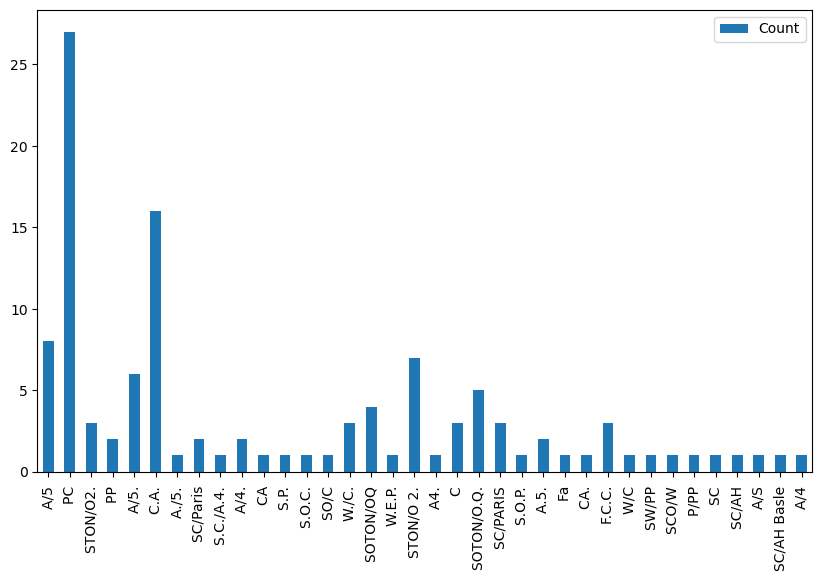

In [15]:
df_prefix.plot(kind='bar', figsize = (10,6) )

In [16]:
#Create a Data frame to compare the survivied attribute with the prefix existence
df_ticket = df_train[['Survived', 'Ticket']].copy()

df_ticket['Ticket prefix']=0
for i, ticket in enumerate(df_ticket['Ticket']):
    prefix = re.search(r'\w+/*.* ', ticket)
    if prefix is not None and prefix[0] in train_tickets_prefixes.keys():
        df_ticket['Ticket prefix'][i] = 1

/tmp/ipykernel_32/3454727247.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket prefix'][i] = 1


In [ ]:
df_ticket

In [ ]:
PlotSurvCorrelation(df_ticket, 'Ticket prefix')

In [17]:
df_ticket['Ticket Len'] = 0
df_ticket['Ticket start'] = 0
df_ticket

,Survived,Ticket,Ticket prefix,Ticket Len,Ticket start
0,0,A/5 21171,1,0,0
1,1,PC 17599,1,0,0
2,1,STON/O2. 3101282,1,0,0
3,1,113803,0,0,0
4,0,373450,0,0,0
...,...,...,...,...,...
886,0,211536,0,0,0
887,1,112053,0,0,0
888,0,W./C. 6607,1,0,0
889,1,111369,0,0,0


In [18]:
#Collect the first number and the length of the ticket sufix to contrast them with the Survived attribute
for i,ticket in enumerate(df_ticket['Ticket']):
    ticket_sufix = re.search(r'\d\d+', ticket)
    if ticket_sufix is not None:
        df_ticket['Ticket Len'][i] = len(ticket_sufix[0])
        df_ticket['Ticket start'][i] = int(ticket_sufix[0][0])

/tmp/ipykernel_32/3405260857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket Len'][i] = len(ticket_sufix[0])
/tmp/ipykernel_32/3405260857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket start'][i] = int(ticket_sufix[0][0])


In [ ]:
df_ticket

In [ ]:
PlotSurvCorrelation(df_ticket, 'Ticket Len')

In [ ]:
PlotSurvCorrelation(df_ticket, 'Ticket start')

In [19]:
#Add the created attributes to the X dataset
ticket_start = pd.DataFrame(processor.encoder.fit_transform(np.array(df_ticket[['Ticket start']])).toarray(), 
                           columns=['Ticket_0', 'Ticket_1', 'Ticket_2', 'Ticket_3', 'Ticket_4', 'Ticket_5', 'Ticket_6', 'Ticket_7', 'Ticket_8', 'Ticket_9'])
ticket_len = processor.scaler.transform(np.array(df_ticket['Ticket Len']).reshape(1, -1))

In [20]:
X['Ticket len']=ticket_len.reshape(-1,1)
X = pd.concat([X, ticket_start], axis='columns')

In [ ]:
X

In [21]:
#All the anterior processing applied to the test dataset
df_ticket = df_test[['Ticket']].copy()

df_ticket['Ticket prefix']=0
for i, ticket in enumerate(df_ticket['Ticket']):
    prefix = re.search(r'\w+/*.* ', ticket)
    if prefix is not None and prefix[0] in train_tickets_prefixes.keys():
        df_ticket['Ticket prefix'][i] = 1
        
df_ticket['Ticket Len'] = 0
df_ticket['Ticket start'] = 0

for i,ticket in enumerate(df_ticket['Ticket']):
    ticket_sufix = re.search(r'\d\d+', ticket)
    if ticket_sufix is not None:
        df_ticket['Ticket Len'][i] = len(ticket_sufix[0])
        df_ticket['Ticket start'][i] = int(ticket_sufix[0][0])

ticket_start = pd.DataFrame(processor.encoder.transform(np.array(df_ticket[['Ticket start']])).toarray(), 
                           columns=['Ticket_0', 'Ticket_1', 'Ticket_2', 'Ticket_3', 'Ticket_4', 'Ticket_5', 'Ticket_6', 'Ticket_7', 'Ticket_8', 'Ticket_9'])
ticket_len = processor.scaler.transform(np.array(df_ticket['Ticket Len']).reshape(1, -1))

X_test['Ticket len']=ticket_len.reshape(-1,1)
X_test = pd.concat([X_test, ticket_start], axis='columns')

/tmp/ipykernel_32/275319505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket prefix'][i] = 1
/tmp/ipykernel_32/275319505.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket Len'][i] = len(ticket_sufix[0])
/tmp/ipykernel_32/275319505.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket start'][i] = int(ticket_sufix[0][0])


#### Exclude columns with too little positive values

In [22]:
columns = []
for name in ['Ticket_0', 'Ticket_1', 'Ticket_2', 'Ticket_3', 'Ticket_4', 'Ticket_5', 'Ticket_6', 'Ticket_7', 'Ticket_8', 'Ticket_9']:
    if X[name].value_counts()[1] < 200:
        columns.append(name)

columns

['Ticket_0',
 'Ticket_4',
 'Ticket_5',
 'Ticket_6',
 'Ticket_7',
 'Ticket_8',
 'Ticket_9']

In [23]:
X.drop(columns, axis=1, inplace=True)
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs,Ticket len,Ticket_1,Ticket_2,Ticket_3
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.030868,0.0,1.0,0.0
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.030868,1.0,0.0,0.0
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.043216,0.0,0.0,1.0
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.037042,1.0,0.0,0.0
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.037042,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.037042,0.0,1.0,0.0
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.037042,1.0,0.0,0.0
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.024695,0.0,0.0,0.0
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.037042,1.0,0.0,0.0


In [24]:
X_test.drop(columns, axis=1, inplace=True)
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs,Ticket len,Ticket_1,Ticket_2,Ticket_3
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.054816,0.0,0.0,1.0
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.054816,0.0,1.0,0.0
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.063952,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.036544,0.0,0.0,1.0
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.045680,1.0,0.0,0.0
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.063952,0.0,0.0,1.0
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0


## Divide Dataset 

In [25]:
#Divide the dataset into train-validation sets to reduce overfitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
print("Training Set lenght: {}".format(len(X_train)))
print("Validation Set lenght: {}".format(len(X_val)))

In [ ]:
X_train.info()

In [ ]:
X_train

In [ ]:
X_test

## Model construction 

### Random Forest

In [ ]:
#Train a random forest classifier with default parameters
clf_rnd = RandomForestClassifier( 
                                 n_jobs=-1, 
                                 random_state=42)
clf_rnd.fit(X_train, y_train)

In [ ]:
predict(X_train, y_train, X_val, y_val, clf_rnd)

In [ ]:
#Now we can get the most important features of our dataset
feature_importances = {name: score for name, score in zip(list(X_train), clf_rnd.feature_importances_)}

In [ ]:
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(20)

In [ ]:
#Create a reduced version of the datasets with the most important features
columns =  [feature for feature in feature_importances_sorted.index if feature_importances_sorted[feature] > 0.02]
X_train_reduced = X_train[columns].copy()
X_val_reduced = X_val[columns].copy()
X_test_reduced = X_test[columns].copy()

In [ ]:
X_train_reduced

#### Search for the best hiperparams with GridSearchCV 

In [26]:
#Search the best hiperparameters for the dataset
param_grid = {"n_estimators": [50, 75, 100], 
               "max_leaf_nodes":[16, 32, None], 
               "min_samples_leaf":[2, 4, 8],
               "max_features": [None, "log2", "sqrt"],
               "max_depth": [16, 32, None], 
               "min_samples_split": [2, 4, 8],
               "criterion": ["gini", "entropy", "log_loss"]} #Hiperparameter combinations

clf_rnd = RandomForestClassifier(random_state=42) # Model instance
grid_rnd = GridSearchCV(clf_rnd, param_grid=param_grid, cv=5, n_jobs=-1) #Grid Search instance
start_time = time.time()
grid_rnd.fit(X_train, y_train) #Model training
end_time = time.time()
final_time = end_time-start_time #Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The training lasted: 0.0 : 15.0 : 17.02


In [ ]:
#Show the parameteres that got the best score
grid_rnd.best_params_

In [ ]:
predict(X_train,y_train,X_val, y_val, grid_rnd)

In [ ]:
grid_rnd.best_score_

In [ ]:
#Feature importance with the new model
feature_importances = {name: score for name, score in zip(list(X_train), grid_rnd.best_estimator_.feature_importances_)}

In [ ]:
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(20)

In [ ]:
important_features = [feature for feature, value in zip(feature_importances_sorted.index, feature_importances_sorted) if value >0.05]
important_features

In [ ]:
X_train_reduced = X_train[important_features].copy()
X_val_reduced = X_val[important_features].copy()
X_test_reduced = X_test[important_features].copy()

### Logistic Regression

In [ ]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train,y_train)

In [ ]:
predict(X_train,y_train, X_val, y_val, clf_lr)

#### Search for the best hiperparams with GridSearchCV 

In [ ]:
param_grid = [{"solver":['lbfgs', 'newton-cg', 'sag'],
              "penalty": ['none', "l2"], 
              "fit_intercept": [True, False], 
              "C": [0.1, 0.5, 1, 5, 10], 
              "max_iter":[50, 100, 150, 200]
              }, 
              {'solver':['liblinear'], 
               'penalty':['l1', 'l2'], 
               "fit_intercept": [True, False], 
               "C": [0.1, 0.5, 1, 5, 10],
              "max_iter":[50, 100, 150, 200]
              }, 
               {'solver': ['saga'], 
                'penalty':['elasticnet'], 
                'l1_ratio': [0.25, 0.5, 0.25], 
                "max_iter":[50, 100, 150, 200]
               }]
               
clf_lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(clf_lr, param_grid=param_grid, cv=5, n_jobs=-1) 
start_time = time.time()
grid_lr.fit(X_train, y_train)
end_time = time.time()
final_time = end_time-start_time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

In [ ]:
grid_lr.best_params_

In [ ]:
predict(X_train,y_train, X_val, y_val, grid_lr)

In [ ]:
grid_lr.best_score_

### Poly SVM

In [ ]:
clf_svm = SVC(kernel="linear", random_state=42)
clf_svm.fit(X_train,y_train)

In [ ]:
predict(X_train ,y_train, X_val, y_val, clf_svm)

#### Search for the best hiperparams with GridSearchCV 

In [28]:
param_grid = {"kernel": ["poly"], 
              "degree": [2, 3], 
              "coef0": [0, 0.1, 1, 5], 
              "C": [0.1, 1, 5], 
              "gamma": [5, 10, 15]}

clf_svm = SVC(random_state=42)
grid_svm = GridSearchCV(clf_svm, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True)
start_time = time.time()
grid_svm.fit(X_train, y_train)
end_time = time.time()
final_time = end_time-start_time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


KeyboardInterrupt: 

In [ ]:
grid_svm.best_params_

In [ ]:
predict(X_train,y_train, X_val, y_val, grid_svm)

In [ ]:
grid_svm.best_score_

### Gaussian SVM

In [ ]:
clf_rbf = SVC(kernel="rbf", random_state=42)
clf_rbf.fit(X_train, y_train)

In [ ]:
predict(X_train,y_train, X_val, y_val, clf_rbf)

#### Search for the best hiperparams with GridSearchCV 

In [29]:
param_grid = {"kernel": ["rbf"], 
            "gamma": [0.01, 0.1, 1, 5, 10, 20, 'scale', 'auto'], 
              "C": [0.01, 0.1, 1, 4, 5, 10, 20],
             "random_state": [42]}

clf_rbf = SVC()
grid_rbf = GridSearchCV(clf_rbf, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True)
start_time = time.time()
grid_rbf.fit(X_train, y_train)
end_time = time.time()
final_time = end_time-start_time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The training lasted: 0.0 : 0.0 : 6.62


In [30]:
grid_rbf.best_params_

{'C': 4, 'gamma': 1, 'kernel': 'rbf', 'random_state': 42}

In [ ]:
predict(X_train,y_train, X_val, y_val, grid_rbf)

In [ ]:
grid_rbf.best_score_

### Naive Bayes 

In [ ]:
clf_nb = BernoulliNB(alpha=1.0e-10)
clf_nb.fit(X_train ,y_train)

In [ ]:
predict(X_train,y_train, X_val, y_val, clf_nb)

#### Search for the best hiperparams with GridSearchCV 

In [ ]:
param_grid = {"alpha":[1.0e-10, 5e-10, 0, 1, 5]}


clf_nb = BernoulliNB()
grid_nb = GridSearchCV(clf_nb, param_grid=param_grid, n_jobs=-1, cv=5)
start_time = time.time()
grid_nb.fit(X_train, y_train)
end_time = time.time()
final_time = end_time-start_time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

In [ ]:
grid_nb.best_params_

In [ ]:
predict(X_train,y_train, X_val, y_val, grid_nb)

In [ ]:
grid_nb.best_score_

### Ridge Classifier

In [ ]:
rdg_clf = RidgeClassifier(random_state=42)

rdg_clf.fit(X_train, y_train)

In [ ]:
predict(X_train, y_train, X_val, y_val, rdg_clf)

#### Search for the best hiperparams with GridSearchCV

In [ ]:
param_grid = [{'alpha':[0.5, 1, 2, 4], 
              'solver': ['svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag', 'auto'], 
              'tol': [1e-4, 1e-3, 1e-2], 
              'positive':[False]}, 
              {'alpha':[0.5, 1, 2 , 4], 
              'solver':['lbfgs', 'auto'], 
              'positive': [True], 
              'tol': [1e-4, 1e-3, 1e-2],
              }]

clf_rdg = RidgeClassifier(random_state=42)
grid_rdg=GridSearchCV(clf_rdg, param_grid=param_grid, cv=5, n_jobs=-1)
start_time = time.time()
grid_rdg.fit(X_train, y_train)
end_time = time.time()
final_time = end_time-start_time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

In [ ]:
grid_rdg.best_params_

In [ ]:
predict(X_train, y_train, X_val, y_val, grid_rdg)

In [ ]:
grid_rdg.best_score_

### SGD Classifier

In [ ]:
clf_sgd = SGDClassifier(random_state=42)

clf_sgd.fit(X_train, y_train)

In [ ]:
predict(X_train, y_train, X_val, y_val, clf_sgd)

#### Search for the best hiperparams with GridSearchCV

In [ ]:
param_grid=[{'loss' :['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 
                      'perceptron', 'squared_error', 'squared_epsilon_insensitive'], 
            'penalty':['l2', 'l1',None], 
            'alpha' : [0.1, 1, 5, 10], 
            'learning_rate': ['constant', 'optimal', 'invscaling'],
            'eta0' : [0.1, 1, 5, 10],
            'early_stopping': [True, False]},
            {'loss' : ['huber', 'epsilon_insensitive'], 
             'penalty' : ['l2', 'l1', None], 
             'alpha' : [0.1, 1, 5, 10],
             'learning_rate': ['constant', 'optimal', 'invscaling'], 
             'eta0' : [0.1, 1, 5, 10],
             'epsilon' :[0, 0.1, 1, 5, 10], 
             'early_stopping': [True, False]}]
            
clf_sgd=SGDClassifier(random_state=42)
grid_sgd=GridSearchCV(clf_sgd, param_grid=param_grid, cv=5, n_jobs=-1)
start_time = time.time()
grid_sgd.fit(X_train, y_train)
end_time = time.time()
final_time = end_time-start_time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

In [ ]:
grid_sgd.best_params_

In [ ]:
predict(X_train, y_train, X_val, y_val, grid_sgd)

In [ ]:
grid_sgd.best_score_

### Perceptron

In [ ]:
clf_pct = Perceptron(random_state=42)

clf_pct.fit(X_train, y_train)

In [ ]:
predict(X_train, y_train, X_val, y_val, clf_pct)

#### Search for the best hiperparams with GridSearchCV

In [ ]:
param_grid=[{'penalty':['l1', 'l2', None], 
            'alpha' : [0,0.01, 0.001, 0.0001, 0.1, 1, 5, 10], 
            'eta0' : [0.1, 1, 5, 10], 
            'early_stopping' :[True, False]}, 
            {'penalty':['elasticnet'], 
            'alpha' : [0,0.01, 0.001, 0.0001, 0.1, 1, 5, 10], 
            'eta0' : [0.1, 1, 5, 10], 
            'early_stopping' :[True, False], 
            'l1_ratio':[0.25, 0.5, 0.25]}
           ]
            

clf_pct = Perceptron(random_state=42)
grid_pct = GridSearchCV(clf_pct, param_grid=param_grid, cv=5, n_jobs=-1)
start_time = time.time()
grid_pct.fit(X_train, y_train)
end_time = time.time()
final_time = end_time-start_time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

In [ ]:
grid_pct.best_params_

In [ ]:
predict(X_train, y_train, X_val, y_val, grid_pct)

In [ ]:
grid_pct.best_score_

### Ensembles: Voting classifier

In [31]:
#Select some classifiers and combine them in a voting classifier
clf_vote = VotingClassifier(estimators=[('Random Forest', grid_rnd.best_estimator_),
                                        ('RBF SVM', grid_rbf.best_estimator_)])
clf_vote.fit(X, y)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=32,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     n_estimators=75,
                                                     random_state=42)),
                             ('RBF SVM', SVC(C=4, gamma=1, random_state=42))])

In [32]:
predict(X_train, y_train, X_val, y_val, clf_vote)

---Training set---

	-Precision Score: 0.956

	-Accuracy Score: 0.857

	-F1 Score: 0.773

	-Recall Score: 0.649

---Validation set---

	-Precision Score: 0.931

	-Accuracy Score: 0.866

	-F1 Score: 0.818

	-Recall Score: 0.730



## Create submission 

In [33]:
final_model = clf_vote

In [34]:
CreateSub(df_test, X_test, final_model, "submission")

In [ ]:
final_model

## Save the model

In [ ]:
#Save the model in memory to conserve it
dump(clf_vote, '/kaggle/working/clf_vote_5.joblib')

### Load anterior model

In [ ]:
clf_vote_1 = load('/kaggle/working/clf_vote_5.joblib')

In [ ]:
clf_vote_1